In [110]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [104]:
data_path = '/batter_data_2010-2019.csv'
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   index_col='Season')
  
  # Data wrangle counting stats
  df['TB'] = df['1B']+df['2B']*2+df['3B']*3+df['HR']*4 # Total bases earned from hitting
  df['BIP'] = df['AB']-df['HR']-df['SO']+df['SF'] # Batted balls in the field of play

  # Data wrangle rate stats
  df['BB%'] = df['BB'] / df['PA'] # Walk rate
  # df['K%'] = df['SO'] / df['PA'] # Strikeout rate omitted due to not being useful to model
  df['SLG'] = df['TB'] / df['AB'] # Total bases per at bat
  df['BABIP'] = (df['H'] - df['HR']) / df['BIP'] # Batting average on balls in play
  df['GB%'] = df['GB'] / (df['BIP'] + df['HR']) # Ground ball rate
  df['BIP%'] = (df['BIP'] + df['HR']) / df['PA'] # Rate of putting ball in play
    
  # Potentially alternative target variables
  # df['ISO'] = (df['TB']-df['H'])/df['AB'] # Total extra bases per at bat
  # df['BPA'] = (df['TB']+df['BB'])/df['PA'] # Total Bases per plate appearance
  # df['SLG_BIP'] = df['TB']/df['BIP'] # Total bases per ball in play

  # Delete unnecessary columns
  df.drop(columns=['playerid', 'Team', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B',
                   'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GB',
                   'FB', 'LD', 'TB', 'BIP', 'wOBA'], inplace=True)
  # Delete variables unrelated to target
  df.drop(columns=['Age',
                   'Zone%',
                   'Z-Swing%',
                   'Contact%',
                   'O-Contact%', 
                   'Z-Contact%',
                   'HardHit%',
                   'Swing%',
                   'SwStr%'], 
                   inplace=True)
  return df
df = wrangle(r'C:\Users\soxsu\Downloads' + data_path)
df.sort_values(by='SLG', ascending=False)

,Name,O-Swing%,Barrel%,BB%,SLG,BABIP,GB%,BIP%
Season,,,,,,,,
2019,Christian Yelich,0.306,0.158,0.137931,0.670757,0.354545,0.430481,0.644828
2015,Bryce Harper,0.276,0.122,0.189602,0.648752,0.369318,0.383249,0.602446
2019,Mike Trout,0.205,0.175,0.183333,0.644681,0.297735,0.242938,0.590000
2018,Mookie Betts,0.198,0.131,0.131922,0.640385,0.368159,0.338710,0.706840
2019,Nelson Cruz,0.305,0.187,0.107486,0.638767,0.350877,0.395706,0.625720
...,...,...,...,...,...,...,...,...
2014,Zack Cozart,0.311,NaN,0.046041,0.300395,0.255319,0.442623,0.786372
2013,Alcides Escobar,0.377,NaN,0.029595,0.299835,0.263862,0.451613,0.820872
2013,Adeiny Hechavarria,0.360,NaN,0.051903,0.298343,0.269663,0.511161,0.775087


In [3]:
df.describe()

,O-Swing%,Barrel%,BB%,SLG,BABIP,GB%,BIP%
count,1429.000000,706.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000
mean,0.303882,0.067950,0.086542,0.446271,0.306192,0.429924,0.718178
std,0.056769,0.037433,0.030932,0.064841,0.032088,0.063262,0.069605
min,0.152000,0.000000,0.015306,0.268499,0.195704,0.242938,0.475564
25%,0.263000,0.040000,0.063683,0.400000,0.284790,0.385047,0.672000
50%,0.302000,0.064500,0.083465,0.441242,0.305851,0.426606,0.719658
75%,0.341000,0.090000,0.105263,0.490385,0.327913,0.471560,0.770393
max,0.490000,0.249000,0.205755,0.670757,0.405970,0.648214,0.883387


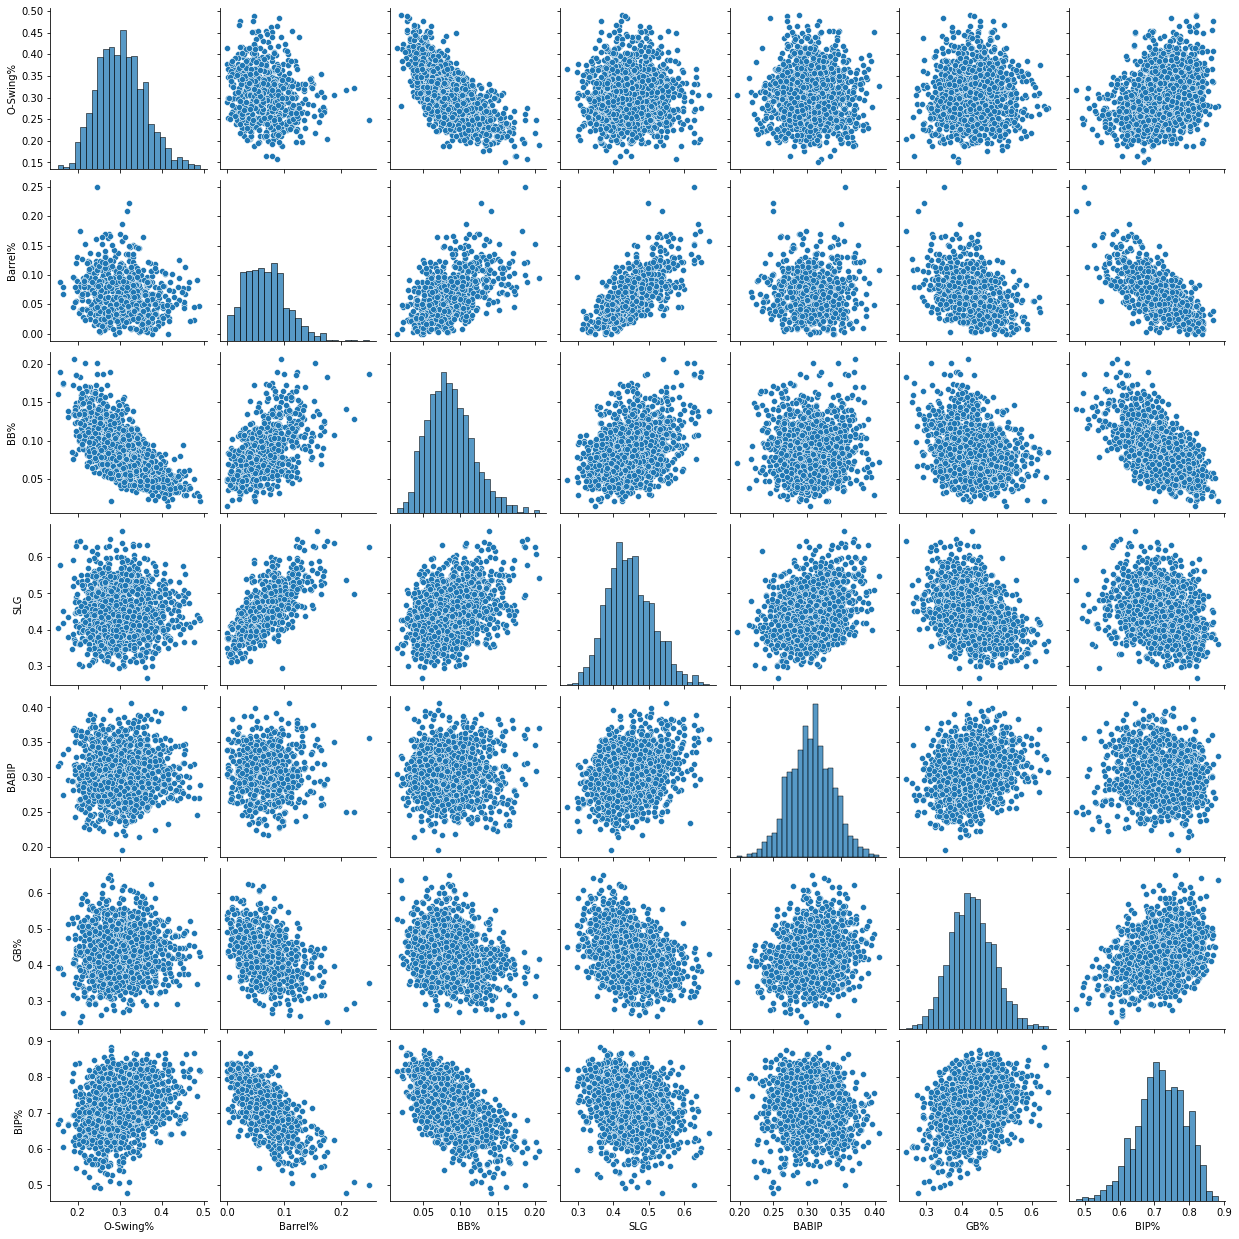

In [4]:
sns.pairplot(df);

In [6]:
# Split into target vector and feature matrix
target = 'SLG'
y = df[target]
X = df.drop(columns=[target, 'Name'])

# Split into train and test data
cutoff = 2018
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [7]:
# Create a baseline accuracy score from the target mean
y_pred = [y_train.mean()]*len(y_train)
print('Mean slugging percentage:', round(y_train.mean(),3))
print('Baseline MAE:', mean_absolute_error(y_train,y_pred))

Mean slugging percentage: 0.442
Baseline MAE: 0.0510563971563173


In [113]:
# Create a linear model
model_lr = make_pipeline(
    StandardScaler(),
    SimpleImputer(),
    LinearRegression()
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [116]:
# Create an extreme gradient boost model
model_xgb = make_pipeline(
    SimpleImputer(),
    XGBRegressor(random_state=42,
                 max_depth=3)
)
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=3, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [117]:
# Check metrics for models
print('LR Training MAE:', mean_absolute_error(y_train,model_lr.predict(X_train)))
print('LR Test MAE:', mean_absolute_error(y_test,model_lr.predict(X_test)))
print('LR Training R-Squared:', r2_score(y_train,model_lr.predict(X_train)))
print('LR Test R-Squared:', r2_score(y_test,model_lr.predict(X_test)))

LR Training MAE: 0.03487270011268653
LR Test MAE: 0.03312819500107661
LR Training R-Squared: 0.5336724534604909
LR Test R-Squared: 0.6145902796758423


In [118]:
print('XBG Training MAE:', mean_absolute_error(y_train,model_xgb.predict(X_train)))
print('XGB Test MAE:', mean_absolute_error(y_test,model_xgb.predict(X_test)))
print('XGB Training R-Squared:', r2_score(y_train,model_xgb.predict(X_train)))
print('XGB Test R-Squared:', r2_score(y_test,model_xgb.predict(X_test)))

XBG Training MAE: 0.019986913973791428
XGB Test MAE: 0.032325358667325735
XGB Training R-Squared: 0.830740219376559
XGB Test R-Squared: 0.6335912312425902


In [119]:
# Hyperparameter Tuning 
estimator = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=42)
)

EARLY_STOP = 50
MAX_ROUNDS = 10_000

params = {
    'xgbregressor__max_depth': range(1,11,1)
}

model_gs = GridSearchCV(
    estimator,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model_gs.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                            

In [120]:
# All potential parameters for tuning
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'xgbregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'xgbregressor__objective', 'xgbregressor__base_score', 'xgbregressor__booster', 'xgbregressor__colsample_bylevel', 'xgbregressor__colsample_bynode', 'xgbregressor__colsample_bytree', 'xgbregressor__gamma', 'xgbregressor__gpu_id', 'xgbregressor__importance_type', 'xgbregressor__interaction_constraints', 'xgbregressor__learning_rate', 'xgbregressor__max_delta_step', 'xgbregressor__max_depth', 'xgbregressor__min_child_weight', 'xgbregressor__missing', 'xgbregressor__monotone_constraints', 'xgbregressor__n_estimators', 'xgbregressor__n_jobs', 'xgbregressor__num_parallel_tree', 'xgbregressor__random_state', 'xgbregressor__reg_alpha', 'xgbregressor__reg_lambda', 'xgbregressor__scale_pos_weight', 'xgbregressor__subsample', 'xgbregressor__tree_method', 'xgbregressor__validate_parameters', 'xgbregressor__verbosity'])

In [121]:
# Check the feature importance
feature_importance_xgb = pd.Series(model_xgb.named_steps['xgbregressor'].feature_importances_,
                                   index=X.columns).sort_values(ascending=False)
feature_importance_xgb

Barrel%     0.298933
GB%         0.212846
BABIP       0.201574
BB%         0.136308
BIP%        0.079976
O-Swing%    0.070363
dtype: float32

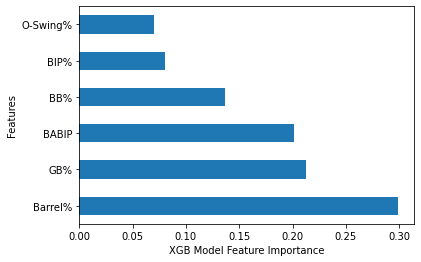

In [122]:
# Plot the feature importance
feature_importance_xgb.plot(kind='barh')
plt.xlabel('XGB Model Feature Importance')
plt.ylabel('Features');

In [123]:
# Check permutation importance
perm_imp = permutation_importance(model_xgb,
                                  X_test,
                                  y_test,
                                  n_jobs=-1,
                                  random_state=42)

perm_imp_xgb = pd.DataFrame({'importance':perm_imp.importances_mean},index=X_test.columns)
perm_imp_xgb

,importance
O-Swing%,0.200400
Barrel%,0.859782
BB%,0.662621
BABIP,0.209225
GB%,0.083574
BIP%,0.386560


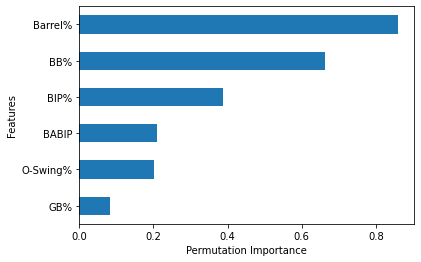

In [124]:
perm_imp_xgb['importance'].sort_values().plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Features');

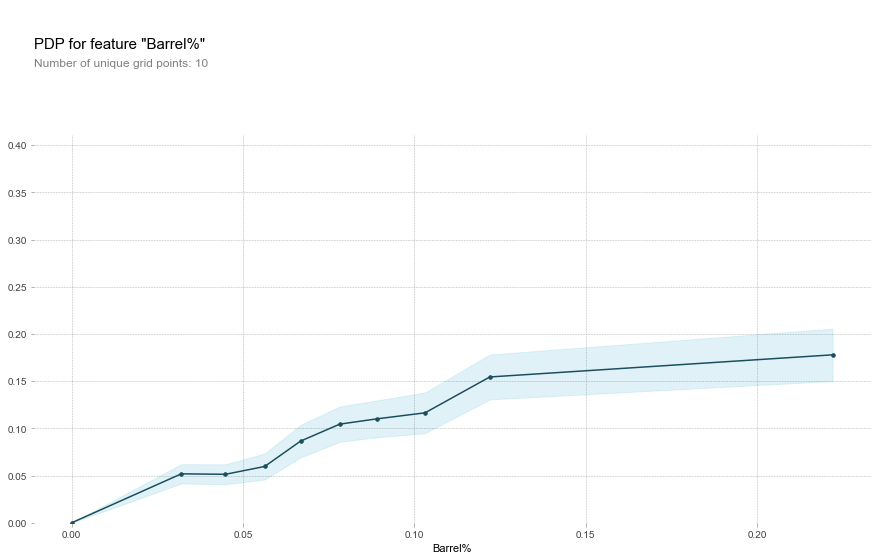

In [125]:
# Create a partial dependence plot for the strongest feature
feature = 'Barrel%'

isolate = pdp_isolate(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

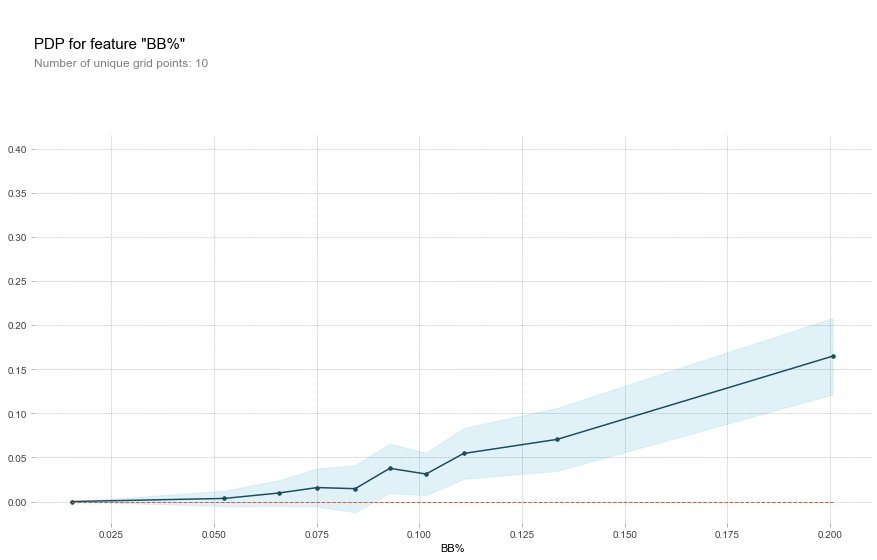

In [126]:
feature = 'BB%'

isolate = pdp_isolate(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

In [127]:
df[(df['Barrel%'] > df['Barrel%'].mean())]['SLG'].mean()

0.49669760214632114

In [128]:
df[(df['Barrel%'] < df['Barrel%'].mean())]['SLG'].mean()

0.42158698157445496

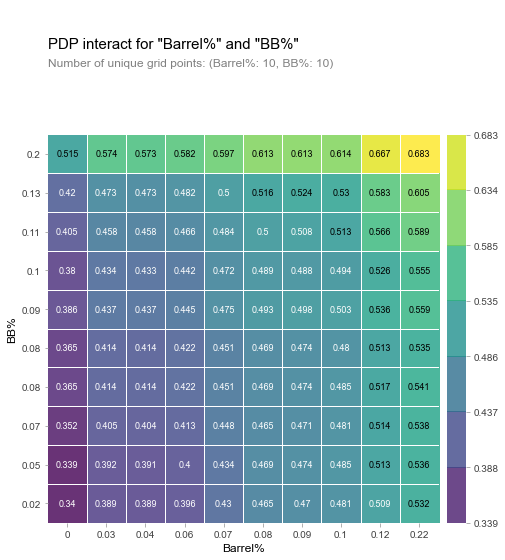

In [129]:
# Check PDP interaction between two somewhat related parameters
features = ['Barrel%','BB%']

interact = pdp_interact(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)
pdp_interact_plot(interact, plot_type='grid', feature_names=features);

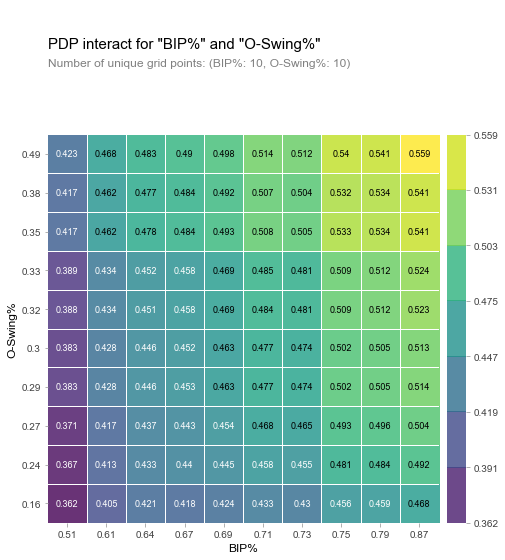

In [130]:
features = ['BIP%','O-Swing%']

interact = pdp_interact(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)
pdp_interact_plot(interact, plot_type='grid', feature_names=features);

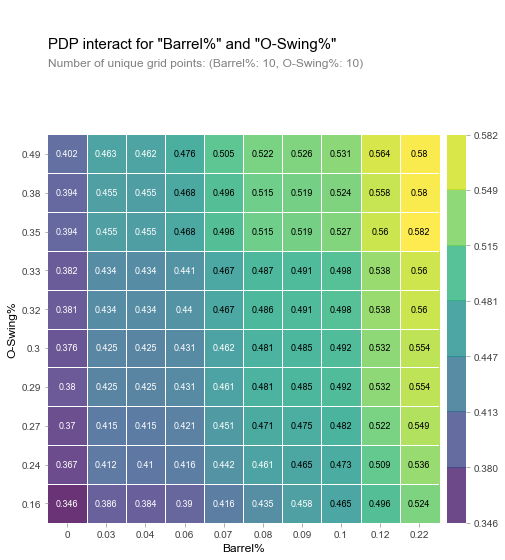

In [131]:
features = ['Barrel%','O-Swing%']

interact = pdp_interact(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)
pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [132]:
df[(df['O-Swing%'] > (df['O-Swing%'].mean() + df['O-Swing%'].std())) & 
   (df['Barrel%'] > (df['Barrel%'].mean() + df['Barrel%'].std()))].head(50)

,Name,O-Swing%,Barrel%,BB%,SLG,BABIP,GB%,BIP%
Season,,,,,,,,
2015,Yoenis Cespedes,0.375,0.107,0.048817,0.541864,0.322511,0.416499,0.735207
2018,Javier Baez,0.455,0.113,0.044961,0.554455,0.347188,0.446953,0.686822
2018,Nicholas Castellanos,0.386,0.106,0.072271,0.500000,0.360802,0.353814,0.696165
2019,Javier Baez,0.441,0.125,0.049911,0.531073,0.344828,0.501326,0.672014
2018,C.J. Cron,0.385,0.119,0.066071,0.493014,0.293051,0.401662,0.644643
2019,Jose Abreu,0.373,0.120,0.051948,0.503155,0.320261,0.463415,0.709957
2019,Eloy Jimenez,0.367,0.122,0.059524,0.512821,0.308197,0.479167,0.666667
2019,Avisail Garcia,0.400,0.106,0.058491,0.464213,0.340058,0.460490,0.692453
2019,Renato Nunez,0.375,0.107,0.073456,0.460259,0.272237,0.325871,0.671119


In [133]:
data_path2 = '/batter_data_2020.csv'
df2 = wrangle(r'C:\Users\soxsu\Downloads' + data_path2)
df2.head()

,Name,O-Swing%,Barrel%,BB%,SLG,BABIP,GB%,BIP%
Season,,,,,,,,
2020,Juan Soto,0.210,0.175,0.209184,0.694805,0.362832,0.515873,0.642857
2020,Freddie Freeman,0.282,0.147,0.171756,0.640187,0.365854,0.316384,0.675573
2020,Marcell Ozuna,0.325,0.154,0.142322,0.635965,0.390728,0.366864,0.632959
2020,DJ LeMahieu,0.289,0.029,0.083333,0.589744,0.369697,0.565714,0.810185
2020,Jose Ramirez,0.259,0.102,0.122047,0.607306,0.293750,0.299435,0.696850


In [134]:
df2[(df2['O-Swing%'] > (df['O-Swing%'].mean() + df['O-Swing%'].std())) & 
   (df2['Barrel%'] > (df['Barrel%'].mean() + df['Barrel%'].std()))].head(50)

,Name,O-Swing%,Barrel%,BB%,SLG,BABIP,GB%,BIP%
Season,,,,,,,,
2020,Dominic Smith,0.371,0.133,0.070352,0.615819,0.368000,0.407407,0.678392
2020,Jose Abreu,0.364,0.143,0.068702,0.616667,0.349693,0.445055,0.694656
2020,Eloy Jimenez,0.411,0.165,0.053097,0.558685,0.340278,0.518987,0.699115
2020,Renato Nunez,0.424,0.121,0.078704,0.492308,0.316667,0.318182,0.611111
2020,Colin Moran,0.387,0.134,0.095000,0.471910,0.290598,0.559055,0.635000
2020,Rafael Devers,0.423,0.121,0.052419,0.482759,0.324675,0.454545,0.665323
2020,Randal Grichuk,0.373,0.112,0.056277,0.481481,0.299363,0.414201,0.731602
2020,Nicholas Castellanos,0.382,0.160,0.078512,0.486239,0.257353,0.346667,0.619835
2020,Luis Robert,0.431,0.128,0.088106,0.435644,0.300000,0.374046,0.577093
